# Customers churn

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones. We need to predict whether a customer will leave the bank soon. 

We have the data on clients’ past behavior and termination of contracts with the bank. We need to build a model with the maximum possible F1 score. 

An F1 score souls be at least 0.59. Check the F1 for the test set. 
Additionally, measure the AUC-ROC metric and compare it with the F1.


Source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Description of the data**

- RowNumber — data string index,
- CustomerId — unique customer identifier,
- Surname — surname,
- CreditScore — credit score,
- Geography — country of residence,
- Gender — gender,
- Age — age,
- Tenure — period of maturation for a customer’s fixed deposit (years),
- Balance — account balance,
- NumOfProducts — number of banking products used by the customer,
- HasCrCard — customer has a credit card,
- IsActiveMember — customer’s activeness,
- EstimatedSalary — estimated salary,
- Exited — сustomer has left.

## Data preparation

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Download the dataset

data = pd.read_csv('/datasets/Churn.csv')

In [3]:
#Check general info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Most of the columns in the dataset have a numeric format, except for the columns Surname, Geography, Gender, which have the object format (it is important for further data processing). There are gaps in the Tenure column that need to be processed.

In [4]:
#Check the first 5 rows of the dataset

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
#Check the lines with the missing value of tenure

data[data['Tenure'].isnull()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [6]:
#Check the values in the column Tenure

data.Tenure.value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

The reason for the missing valuese in the Tenure column is not obvious based on the data, it makes sense to contact the developers for additional verification of the reason for the it. In this case, it is decided to fill in the gaps with the median value of the Tenure column.

In [7]:
#Fill in the gaps in the Tenure column with the median value and replace the data type with int

data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median()).astype('int')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
#Check duplicates

data.duplicated().sum()

0

There are no duplicates in the dataset.

Exclude RowNumber, CustomerID, and Surname columns from the dataset because these columns do not affect the value of the target attribute.

In [10]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

Since the data contains categorical features, an error may occur when training the model. Transform categorical features into numerical using the OHE direct coding technique.

In [11]:
#Convert categorical variables into numerical

data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Conclusion

During data preparation, missing values in the Tenure column were identified, filled in with median values and changed to an integer format; three columns were excluded from the dataset; categorical variables were converted to numerical ones.

## Investigation of the task.

To begin the study, select dataset with features and target feauture. Divide the sample into training, validation and test samples and check the value of the F1 measure and accuracy for different models.

In [12]:
#Split the data into a training sample and data for validation and test

data_train, data_other = train_test_split(data_ohe, test_size=0.4, random_state=12345)

In [13]:
#Split data_other into two separate samples for validation and testing of the model

data_valid, data_test = train_test_split(data_other, test_size=0.5, random_state=12345)

In [14]:
#Check the sizes of the samples

print('Training data size:', data_train.shape[0])
print('Validating data size:', data_valid.shape[0])
print('Testing data size:',data_test .shape[0])

Training data size: 6000
Validating data size: 2000
Testing data size: 2000


In [15]:
# Select a dataset with features for each sample

#Select a dataset with features for training
features_train = data_train.drop('Exited', axis=1)

#Select a dataset with features for validation
features_valid = data_valid.drop('Exited', axis=1)

#Select a dataset with features for test
features_test = data_test.drop('Exited', axis=1)

In [16]:
# Select a target for each sample

#Select a target for training
target_train = data_train['Exited']

#Select a target for validation
target_valid = data_valid['Exited']

#Select a target for test
target_test = data_test['Exited']

In [17]:
#Standardizing numerical features in a dataset

scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [18]:
#Train a Logistic Regression model and calculate the F1 measure and accuracy for this model

model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
score = f1_score(target_valid, predicted_valid)
accuracy_valid = accuracy_score(predicted_valid, target_valid)
print('Accuracy:',accuracy_valid) 
print('F1 score:', score)

Accuracy: 0.802
F1 score: 0.33108108108108103


In [19]:
#Train the Decision Tree model and check its accuracy and F1 measurements with a tree depth from 1 to 9

best_depth = 0
best_result = 0
best_score = 0

for depth in range(1,10):
    #train a model with a given tree depth
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    #train the model
    model.fit(features_train, target_train)
    #get the prediction of the model on the validation sample
    predicted_valid = model.predict(features_valid)
    #calculate the quality of the model on the validation sample
    result = accuracy_score(target_valid,predicted_valid) 
    score = f1_score(target_valid,predicted_valid)
    if result > best_result and score > best_score:
        best_depth = depth
        best_result = result
        best_score = score
print('Accuracy лучшей модели:', best_result)
print('F1 лучшей модели:', best_score)
print('Глубина дерева:', best_depth)

Accuracy лучшей модели: 0.858
F1 лучшей модели: 0.5696969696969697
Глубина дерева: 6


In [20]:
#Train a Random Forest model and check its accuracy with the number of trees from 1 to 9 and the depth of the tree from 10 to 100 in est of 10
best_est = 0
best_result = 0
best_score = 0
best_depth = 0

for depth in range(1,10):
    for est in range(10,100,10):
        #train a model with a given number of trees and a given tree depth
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth) 
        #train the model
        model.fit(features_train, target_train) 
        #get the prediction of the model on the validation sample
        predicted_valid = model.predict(features_valid)
        #calculate the quality of the model on the validation sample
        result = accuracy_score(target_valid,predicted_valid) 
        score = f1_score(target_valid,predicted_valid)
        if result > best_result and score > best_score:
            best_est = est
            best_depth = depth
            best_result = result
            best_score = score   
print('Accuracy лучшей модели:', best_result)
print('F1 лучшей модели:', best_score)
print('Глубина дерева:', best_depth)
print('Количество деревьев:', est)

Accuracy лучшей модели: 0.8645
F1 лучшей модели: 0.5705229793977813
Глубина дерева: 8
Количество деревьев: 90


In [21]:
#Check the Confusion matrix for the Random Forest model with a tree depth of 8 and a number of trees of 90

model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth = 8, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
confusion_matrix(target_valid, predicted_valid)

array([[1376,  206],
       [ 134,  284]])

### Conclusion

The best accuracy and F1 measurements were demonstrated by the Random Forest model with a tree depth of 8 and a number of trees of 90.

Based on the Confusion matrix, we can conclude that the data set contains more negative values than positive ones, respectively, they need to be balanced to obtain a more accurate forecast.

The higher the F1 value of the measure (the closer it is to 1), the better the model, in our case, the indicator of the Random Forest model is 0.57, let's try to improve it by balancing classes.

## Balancing classes.

Try to solve the problem of imbalance by weighing classes.

In [22]:
#Balance the classes by adding the class_weight='balanced' parameter to the Decision Tree model and calculate the F1 measure

model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth = 8, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_score(target_valid, predicted_valid)


0.6255506607929514

The F1 measure increased after the classes were weighed. 

let's also test the techniques of upsampling and downsampling and check the F1 measure for these approaches.

In [23]:
#Train the model with upsampling

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

for repeat in range(3,22,3):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)

    model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth = 8)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('F1 score:', f1_score(target_valid, predicted_valid),'|', 'repeat:', repeat)

F1 score: 0.6360424028268551 | repeat: 3
F1 score: 0.5832614322691976 | repeat: 6
F1 score: 0.5353159851301116 | repeat: 9
F1 score: 0.4966532797858099 | repeat: 12
F1 score: 0.46642246642246643 | repeat: 15
F1 score: 0.44845661036691903 | repeat: 18
F1 score: 0.4396600566572238 | repeat: 21


In [24]:
#Train the model with downsampling

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

for fraction in np.arange(0.01, 0.25, 0.03):
    features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
    model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth = 8)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    print('F1 score:', f1_score(target_valid, predicted_valid),'|', 'fraction:', fraction)    

F1 score: 0.34602649006622516 | fraction: 0.01
F1 score: 0.3685612788632327 | fraction: 0.04
F1 score: 0.4144805876180483 | fraction: 0.06999999999999999
F1 score: 0.45790430042398544 | fraction: 0.09999999999999999
F1 score: 0.5086385625431928 | fraction: 0.13
F1 score: 0.5296324081020256 | fraction: 0.16
F1 score: 0.5635910224438903 | fraction: 0.19
F1 score: 0.5749559082892416 | fraction: 0.22


### Conclusion

According to the results of different approaches to data balancing, the highest value of the F1 measure was achieved by increasing the sample with a factor of 3.

## Model testing

In [25]:
#Test the Decision Tree model on a test sample with the selected parameters
#and taking into account the balancing of classes.

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth = 8) 
model.fit(features_upsampled, target_upsampled)
predicted_test= model.predict(features_test)
result = accuracy_score(target_test,predicted_test) 
score = f1_score(predicted_test,target_test)

print('Accuracy лучшей модели:', result)
print('F1 лучшей модели:', score)


Accuracy лучшей модели: 0.8305
F1 лучшей модели: 0.6025791324736226


The model showed the F1 value of 0.603 when tested on a test sample.

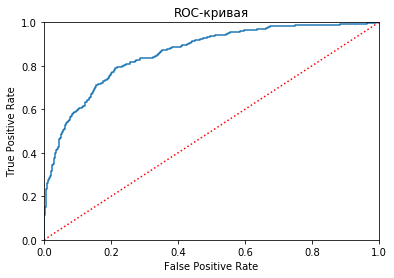

AUC_ROC: 0.8589850255819845


In [26]:
#Create a ROC curve for the Decision Tree model and find the AUC_ROC.

probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC-кривая')
plt.plot([0, 1], [0, 1], ":r", label = 'ROC-кривая случайной модели')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show();

auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('AUC_ROC:',auc_roc)

### Conclusion

Random Forest model showed an F1 measure equal to 0.603, and AUC_ROC value of 0.86 on a test sample, which is significantly higher than the 0.5 characteristic of the random model. Thus, our model predicts better than the random model.

## General conclusion

The following steps were carried out during the project:

+ data uploaded and prepared;

+ three models were trained: Logistic Regression, Decision Tree Classifier, Random Forest Classifier. According to the results of the initial measurement of accuracy and F1 measurements, the RandomForestClassifier model with a tree depth of 8 and a number of trees of 90 turned out to be the most accurate;

+ an imbalance of classes was revealed;

+ to balance the classes, the methods of upsampling, downsampling we used, as well as the weighting method (by adding the class_weight='balanced' parameter to the model); upsampling with a coefficient 3 showed the best result.

+ the model was tested on a test dataset, the indicators of F1 and AUC_ROC showed that the model predicts well with F1 measure equal to 0.603, and AUC_ROC value of 0.86;